In [122]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [123]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [124]:
# Allows to look for null values
df.info()
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [125]:
# Maps gender stirngs to integers so they can be used on the models.
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1}).astype(int)
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1}).astype(int)


In [126]:
# Extracting the titles from the names. Some of them are rare so they will be replace with 'Rare'
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(df['Title'], df['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


In [127]:
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                   'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                   'Jonkheer', 'Dona'], 'Rare')

df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')


In [128]:
df_test['Title'] = df_test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# Some of these occurences are so rare that they will be replaced by
# 'Rare' instead
df_test['Title'] = df_test['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                             'Don', 'Dr', 'Major', 'Rev',
                                             'Sir', 'Jonkheer',
                                             'Dona'], 'Rare')

df_test['Title'] = df_test['Title'].replace('Mlle', 'Miss')
df_test['Title'] = df_test['Title'].replace('Ms', 'Miss')
df_test['Title'] = df_test['Title'].replace('Mme', 'Mrs')


In [129]:
df['Title'] = df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3,
                               "Master": 4, "Rare": 5})

df_test['Title'] = df_test['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3,
                                         "Master": 4, "Rare": 5})

df['Title'].fillna(0, inplace=True)
df_test['Title'].fillna(0, inplace=True)


In [130]:
df['Embarked'].value_counts()
# Shows that Southampton has the majority of
# embarks, hence NaNs are filled with S.

df['Embarked'].fillna('S', inplace=True)
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
df_test['Embarked'].fillna('S', inplace=True)
df_test['Embarked'] = df_test['Embarked'].map(
    {'S': 0, 'C': 1, 'Q': 2}).astype(int)


In [131]:
df['Has_Cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
df_test['Has_Cabin'] = df_test["Cabin"].apply(
    lambda x: 0 if type(x) == float else 1)

df['Is Alone'] = (df['SibSp'] + df['Parch']) == 0
df_test['Is Alone'] = (df_test['SibSp'] + df_test['Parch']) == 0
df['Is Alone'] = df['Is Alone'].map({True: 1, False: 0}).astype(int)
df_test['Is Alone'] = df_test['Is Alone'].map({True: 1, False: 0}).astype(int)


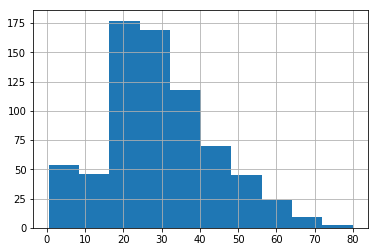

In [132]:
def plot_hist_with_null(ages):
    plt.hist(ages[ages.notnull()])
    plt.grid(True)
    plt.show()


plot_hist_with_null(df['Age'])

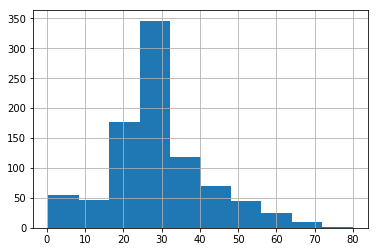

In [133]:
df['Age'].isnull().values.any()  # Checks for nans in age and returns true
df_test['Age'].isnull().values.any()  # Checks for nans in age and returns true
med = df['Age'].median()
med_test = df_test['Age'].median()

df['Age'].fillna(med, inplace=True)
df_test['Age'].fillna(med_test, inplace=True)
# Replace age with median did not affect data set at first sight

plot_hist_with_null(df['Age'])

In [134]:
encoder = LabelEncoder()
df_board = df['Embarked'].apply(str)
df_board_test = df_test['Embarked'].apply(str)
df_board_encoded = encoder.fit_transform(df_board)
df_board_test_encoded = encoder.fit_transform(df_board_test)


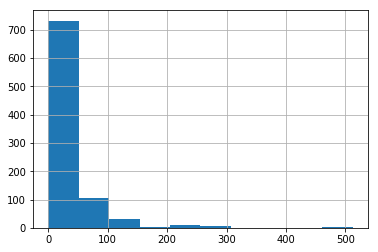

In [135]:
plot_hist_with_null(df['Fare'])
df_test['Fare'].isnull().values.any()
med = df_test['Fare'].median()
# This replacement sounds fishy as the dat distribution is weird.
df_test['Fare'].fillna(med, inplace=True)


In [136]:
y = df['Survived']
X = df.drop(['Survived', 'PassengerId', 'Ticket',
             'Name', 'Cabin'], axis=1)
X_test = df_test.drop(['PassengerId', 'Ticket',
                       'Name', 'Cabin'], axis=1)



In [137]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--",
             label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


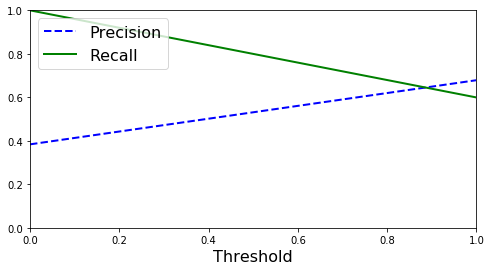

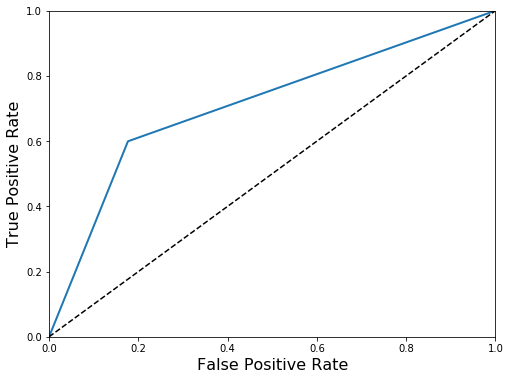

Test shape OK


In [138]:
model = SVC(kernel="rbf", C=3)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model.fit(X_scaled, y)

scores = cross_val_score(model, X, y,
                         scoring="neg_mean_squared_error", cv=10,
                         verbose=1, n_jobs=-1)

rmse_scores = np.sqrt(-scores)
rmse_scores.mean()
rmse_scores.std()


y_scores = cross_val_predict(model, X, y, cv=5)

precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0, 1])
plt.show()

fpr, tpr, thresholds = roc_curve(y, y_scores)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

roc_auc_score(y, y_scores)
X_test_scaled = scaler.fit_transform(X_test)

ytest = model.predict(X_test_scaled)
df_test['Survived'] = ytest
print('Test shape OK') if df_test.shape[0] == ytest.shape[0] else print('Oops')
df_test[['PassengerId', 'Survived']].to_csv(
    'titanic_submission.csv.gz', index=False, compression='gzip')

